In [58]:
import matplotlib
import data_collector as dc
import pandas as pd
import pathlib
import urllib.request
import geopandas as gpd
import ipywidgets as widgets
import folium
import importlib

In [59]:
import geo_information as geo
import data_processing as dproc
importlib.reload(geo)
geo_information = geo.GeoInformation()

In [60]:
importlib.reload(dproc)
dp = dproc.Data_Processor()
dp._create_tables()
dp._populate_pc_data_table()
dp.standardize_data()
dp.run_PCA()

/home/alistair/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (169,170) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/alistair/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (403,404,435,436) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/alistair/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (295,296,297,298,352,399,400,527,528) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [61]:
selected_state = widgets.Dropdown(options=sorted(geo_information.get_states()))

In [77]:
selected_state

Dropdown(index=6, options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut'…

In [78]:
geo_information.set_active_state(selected_state.value)
state_metros = geo_information.get_state_metros(selected_state.value)
selected_metro = widgets.Dropdown(options = state_metros)

In [80]:
selected_metro

Dropdown(index=2, options=('Bridgeport-Stamford-Norwalk, CT', 'Hartford-East Hartford-Middletown, CT', 'New Ha…

In [81]:
geo_information.set_active_metro(selected_metro.value)

In [82]:
# initialize plot stuff & save geojson file
plt_data = geo_information.set_plot_data()
plt_data.to_file('metro_area.json',driver = 'GeoJSON')

In [106]:
puma_map = folium.Map(location = geo_information.get_active_city_location(), zoom_start = 6)
folium.Choropleth(geo_data='metro_area.json',
                  data = dp.finalDF,
                  columns = ['GEO.id2','PC1'],
                  key_on='properties.GEOID10',
                  fill_color='GnBu',
                  fill_opacity=0.6,
                  line_opacity=0.4,
                  legenend_name='test',
                  name='choropleth').add_to(puma_map)

In [107]:
puma_map

### Validation

Next, we consider two ideas for validating the model (i) modeling effectivess and (ii) an analysis of the individual principle components.

In [89]:
def get_city_state(geoname_str):
    city_state_split = geoname_str.split(',')
    city = city_state_split[0]
    state = city_state_split[1].split('(')[0].strip(' ')
    return city, state

In [90]:
def get_city(geoname_str):
    city = geoname_str.split('(')[0]
    return city

In [91]:
new_dataframe_train = pd.DataFrame(columns=['pc1','pc2','gdp'])
new_dataframe_test = pd.DataFrame(columns=['pc1','pc2','gdp'])


In [92]:
for index, row in dp.metro_gdp_df.iterrows():
    if index <=300:
        city, state_abb = get_city_state(row['GeoName'])
        state_abb = state_abb.split('-')[0]
        city_with = get_city(row['GeoName'])
        state = dp.state_abb_df[dp.state_abb_df['Abbrev']==state_abb]['State'].iloc[0].strip(' ')
        geo_information.set_active_state(state)
        geo_information.set_active_metro(city_with[:-1])
        metro = geo_information.get_active_metro()
        geo_information.get_metro_counties(metro)
        get_geo_ids = geo_information.set_plot_data()['GEOID10']
        new_dataframe_train.loc[metro] = (dp.finalDF[dp.finalDF['GEO.id2'].isin(get_geo_ids.array)][['PC1']].mean()[0],
                                        dp.finalDF[dp.finalDF['GEO.id2'].isin(get_geo_ids.array)][['PC2']].mean()[0],
                                        row['percent_chg'])
    if index > 300:
        city, state_abb = get_city_state(row['GeoName'])
        state_abb = state_abb.split('-')[0]
        city_with = get_city(row['GeoName'])
        state = dp.state_abb_df[dp.state_abb_df['Abbrev']==state_abb]['State'].iloc[0].strip(' ')
        geo_information.set_active_state(state)
        geo_information.set_active_metro(city_with[:-1])
        metro = geo_information.get_active_metro()
        geo_information.get_metro_counties(metro)
        get_geo_ids = geo_information.set_plot_data()['GEOID10']
        new_dataframe_test.loc[metro] = (dp.finalDF[dp.finalDF['GEO.id2'].isin(get_geo_ids.array)][['PC1']].mean()[0],
                                        dp.finalDF[dp.finalDF['GEO.id2'].isin(get_geo_ids.array)][['PC2']].mean()[0],
                                        row['percent_chg'])

In [93]:
from sklearn import linear_model
import numpy as np

regr = linear_model.LinearRegression()
regr.fit(new_dataframe_train[['pc1','pc2']].fillna('0'),new_dataframe_train['gdp'])
regr_pc1 = linear_model.LinearRegression()
regr_pc1.fit(new_dataframe_train[['pc1']].fillna('0'),new_dataframe_train['gdp'])
regr_pc2 = linear_model.LinearRegression()
regr_pc2.fit(new_dataframe_train[['pc2']].fillna('0'),new_dataframe_train['gdp'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

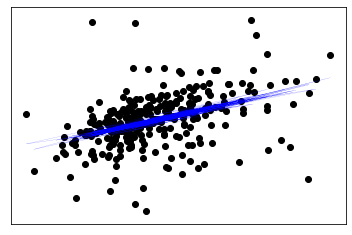

In [100]:
import matplotlib.pyplot as plt

plt.scatter(new_dataframe_train['pc1'], new_dataframe_train['gdp'],  color='black')
plt.plot(new_dataframe_train['pc1'], regr.predict(new_dataframe_train[['pc1','pc2']].fillna('0')), color='blue', linewidth=0.1)
plt.xticks(())
plt.yticks(())
plt.show()

In [101]:
regr.coef_

array([0.02228399, 0.01042774])

In [102]:
regr.score(new_dataframe_test[['pc1','pc2']].fillna('0') ,new_dataframe_test['gdp'])

0.28284161057737356

In [103]:
regr_pc1.score(new_dataframe_test[['pc1']].fillna('0'), new_dataframe_test['gdp'])

0.2746534305798216

In [104]:
regr_pc2.score(new_dataframe_test[['pc2']].fillna('0'), new_dataframe_test['gdp'])

0.017272338712642

### Analysis of individual components

In [55]:
list(dp.pca.components_)[1][9]

-0.12945253212082064

In [ ]:
list(dp.pca.components_)[0][9]

In [ ]:
dp.pca_data_frame.columns.get_loc('ROYADHIUSDP02_PC')

In [ ]:
dp.pca_data_frame